In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import copy
import sys

import numpy as np
import matplotlib.pyplot as plt
#import src.diffusion_map as dmap
#import src.helpers as helpers
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # default is 75
plt.style.use('default')

import math

sys.path.insert(0, "..")
import dMap_based.models, dMap_based.utils, dMap_based.utils_LJ7
from utils_NN import LJ7_2,chiAB,q_theta

Using cpu device


In [4]:
model_output = 'model_output/'
data_folder = 'data/'
filename = data_folder + 'LJ7delta_net.txt'
# filename = datafolder + 'LJ7bins_confs.txt'

txtfile = True

if txtfile:
    import re
    sigma = 0.02

    LJtraj = [] 
    with open(filename, "r") as f:
        for line in f:
            # cleaning the bad chars in line
            line = line.strip()
            line = line.strip(" \\n")
            line = re.sub(r"(-[0-9]+\.)", r" \1", line)
            values = [float(value) for value in line.split()]
            LJtraj.append(values)
    data = np.array(LJtraj)
    print('adjusted data shape: ',np.shape(LJtraj))
else:
    data = np.loadtxt(adj_file,delimiter=",")

adjusted data shape:  (16878, 14)


# diffusion net based

In [11]:
sys.modules['models'] = dMap_based.models

use_C = False
MEP_loss = True
knn = 4160
epsilon = 1

AE_model = torch.load(model_output + f'{example}_CVlearner_2D_crdnum_{use_C}_mep_{MEP_loss}.pt',map_location=torch.device('cpu') )

DDnet = torch.load(output_folder + f"{example}_DDnet_knn{knn}_eps{epsilon}_BinsConf_CrdNum.pt",map_location=torch.device('cpu'))

manifold = torch.load(model_output + f"{example}_manifold_learner_knn{knn}_eps{epsilon}_CrdNum.pt",map_location=torch.device('cpu'))
ptsClound = np.loadtxt(data_folder + f"ptsCloud_knn{knn}_eps{epsilon}_CrdNum.csv",delimiter=",").astype(np.float32)

pts_off = torch.from_numpy(ptsClound)

target= np.loadtxt(data_folder + f"{example}_eigens_knn{knn}_eps{epsilon}_CrdNum.csv", delimiter=',').astype(np.float32)

feature_data = (torch.from_numpy(dMap_based.utils_LJ7.sort_r2(data))).to(torch.float32)


target= np.loadtxt(data_folder + 'LJ8_eigens_knn1_eps3.csv', delimiter=',').astype(np.float32)

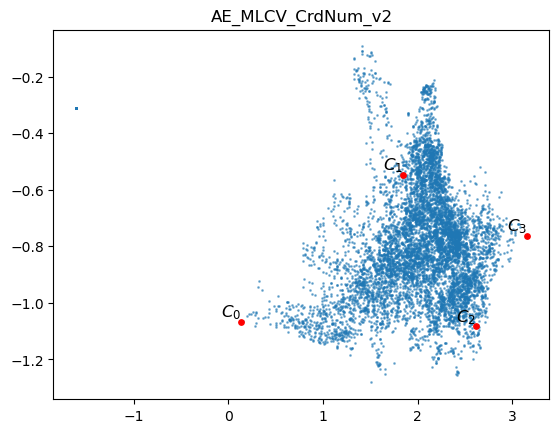

In [10]:
# CV space
CV_dmap,recon = AE_model(feature_data)
CV_dmap = CV_dmap.detach().numpy()

if CV_dmap.shape[1] == 2:
    plt.scatter(CV_dmap[:,0],CV_dmap[:,1], s = 1, alpha = 0.5)
    # plt.colorbar()
    plt.scatter(CV_dmap[-4:, 0], CV_dmap[-4:, 1], c='red', s=15)

    for i, (x, y) in enumerate(CV_dmap[-4:]):
        plt.text(x, y, f"$C_{i}$", fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    plt.title("AE_MLCV_CrdNum_v2")
    plt.savefig('figures/CV2D_LJ7_crdnum.pdf')
    plt.show()

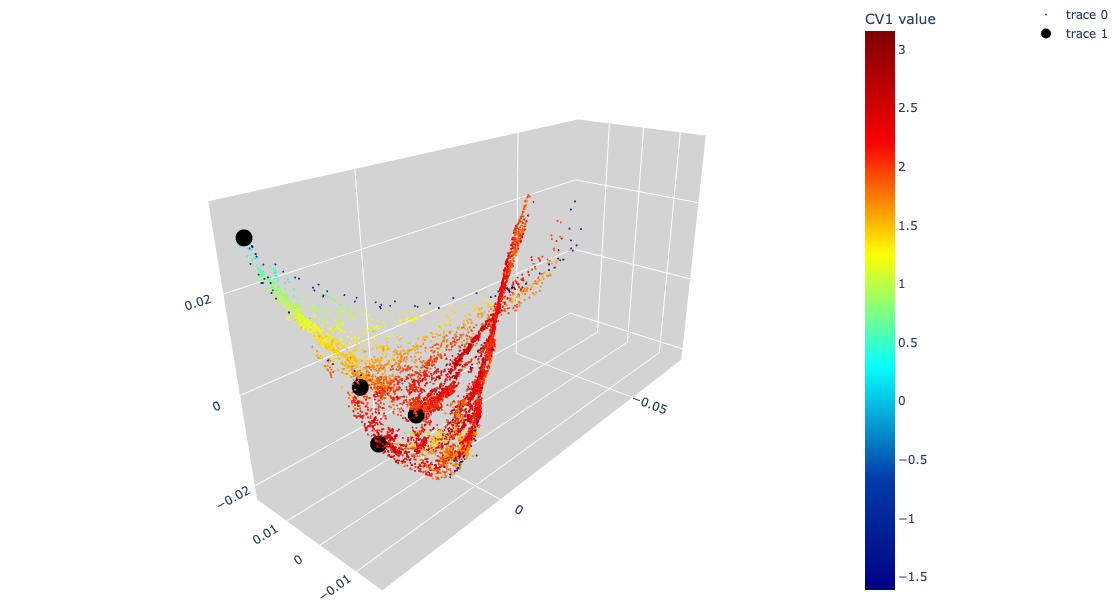

In [71]:
evecs = DDnet(feature_data).detach().numpy()

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Scatter3d(
        x=evecs[:, 0], 
        y=evecs[:, 1], 
        z=evecs[:, 2], 
        mode='markers',
        marker=dict(
            size=1.2,
            color=CV_dmap[1:,0],  # Set color for points
            colorscale='Jet',  # Choose a colorscale (e.g., Viridis, Plasma, Jet, etc.)
            colorbar=dict(
                title='CV1 value',
                x=0.85,  # Move colorbar closer to the plot (adjust between 0.8–0.9)
                len=0.9  # Optional: shorten the colorbar if too long
            ),  # Add a colorbar
            opacity=0.8
        )
    )
])
labels = [f"C{i}" for i in range(4)]  

fig.add_trace(go.Scatter3d(
    x=evecs[-4:, 0], 
    y=evecs[-4:, 1], 
    z=evecs[-4:, 2], 
    mode='markers',  # Enables both markers and text
    # text=labels,  # Text labels for each point
    textposition="top right",  # Adjust text position relative to points
    marker=dict(
        size=10,
        color='black',  # Varying color values
        # colorscale='Reds',  # Shades of red
        # colorbar=dict(title='Intensity'),  # Optional colorbar
    )
))

# fig.update_layout(title="Interactive Rotational 3D Plot")
camera = dict(
    eye=dict(x=-1.5, y=1.8, z=1)  # Adjust x, y, z for the desired angle
)

# Update Layout
fig.update_layout(
    scene_camera=camera,
    scene=dict(
        xaxis_title=r"",  # Custom X-axis label
        yaxis_title=r"",  # Custom Y-axis label
        zaxis_title=r"",  # Custom Z-axis label
        xaxis=dict(backgroundcolor='lightgrey', gridcolor='white'),  # Custom X-axis background
        yaxis=dict(backgroundcolor='lightgrey', gridcolor='white'),  # Custom Y-axis background
        zaxis=dict(backgroundcolor='lightgrey', gridcolor='white')   # Custom Z-axis background
    ),
    width=800,  # Set figure width
    height=600,  # Set figure height
    margin=dict(l=0, r=0, b=0, t=0),  # Set margins
    paper_bgcolor='white',  # Background color outside the plot
    plot_bgcolor='grey'  # Background color inside the plot
)

fig.write_image("figures/manifold_crdnum.pdf")
fig.show()



tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.9950, grad_fn=<MeanBackward0>)
(21645, 1)


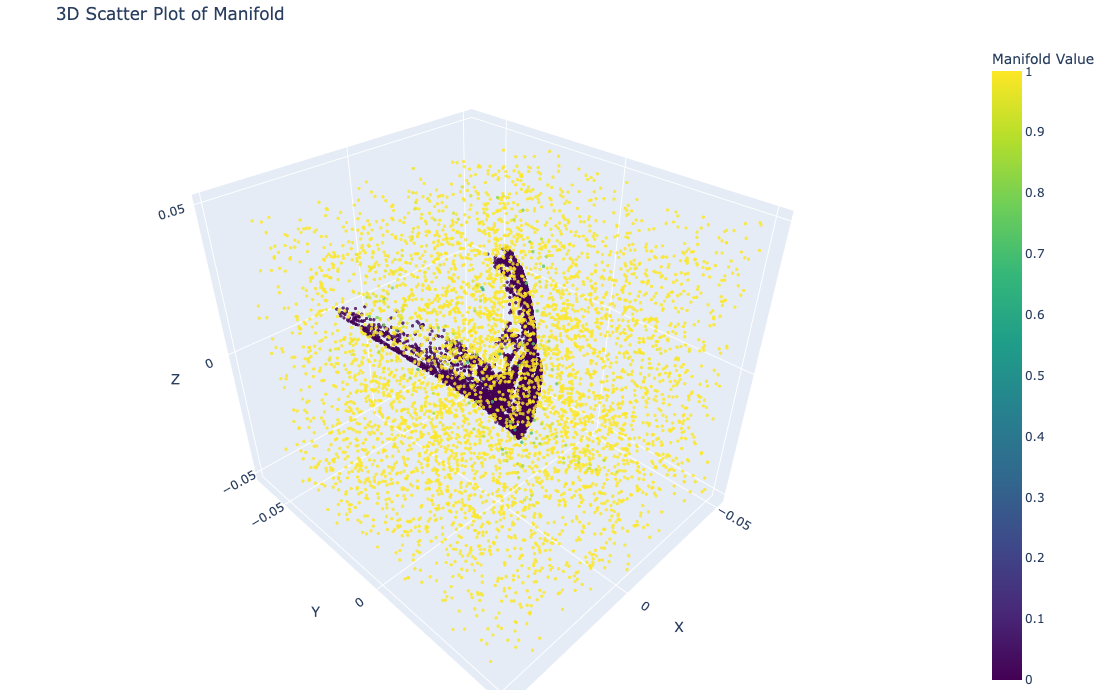

In [ ]:
Manifold_on = manifold(torch.from_numpy(target))
Manifold_off = manifold(pts_off)

print(Manifold_on.mean())
print(Manifold_off.mean())

All_pts = np.append(target, ptsClound, axis = 0)
manifold_value = np.append(Manifold_on.detach().numpy(),Manifold_off.detach().numpy(), axis = 0)

fig = go.Figure()

# Add scatter plot for the points with color mapping
fig.add_trace(go.Scatter3d(
    x=All_pts[:, 0], 
    y=All_pts[:, 1], 
    z=All_pts[:, 2], 
    mode='markers',
    marker=dict(
        size=2,  # Increase size slightly for visibility
        color=manifold_value[:,0],  # Use manifold_value for color mapping
        colorscale='Viridis',  # Change this to your preferred color scale (e.g., 'Jet', 'Plasma', etc.)
        colorbar=dict(title='Manifold Value'),  # Add a colorbar
        opacity=0.8
    )
))

# Update layout
fig.update_layout(
    title="3D Scatter Plot of Manifold",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
    ),
    width=800,
    height=700,
    margin=dict(l=10, r=10, b=10, t=40),
    # paper_bgcolor="white",
    # plot_bgcolor="lightgrey"
)

# Show the interactive plot
fig.show()